In [1]:
import io
import requests

from PIL import Image as im

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('talk')

# Upload data

In [2]:
import pandas as pd

pdf = pd.read_parquet('../../ftransfer_ztf_2024-02-01_689626')


In [ ]:
pdf.head(3)

# Select alerts with shared Id.

In [6]:
Id = pdf['objectId'][4771]

id_plus_repete = pdf['objectId'].value_counts().idxmax()

# We select data based on their shared ID, (here opting for the most frequently occurring alert).
pdf_selectionne = pdf.loc[pdf['objectId'] == id_plus_repete]



In [7]:
pdf_selectionne.head(2)

,candid,schemavsn,publisher,objectId,candidate,prv_candidates,cutoutScience,cutoutTemplate,cutoutDifference,cdsxmatch,...,fink_broker_version,fink_science_version,timestamp,year,month,day,tnsclass,lc_features_g,lc_features_r,finkclass
9095,1356463051915015005,3.3,Fink,ZTF18adbmoft,"{'aimage': 0.6380000114440918, 'aimagerat': 0....","[{'aimage': None, 'aimagerat': None, 'bimage':...",{'fileName': 'candid1356463051915015005_pid135...,{'fileName': 'candid1356463051915015005_ref.fi...,{'fileName': 'candid1356463051915015005_pid135...,Candidate_YSO,...,1.4,0.5.1,2020-09-18 11:06:48.003835,2020,9,18,Unknown,"{'amplitude': 0.3285503387451172, 'anderson_da...","{'amplitude': None, 'anderson_darling_normal':...",Candidate_YSO
9096,1356452581915015002,3.3,Fink,ZTF18adbmoft,"{'aimage': 0.7609999775886536, 'aimagerat': 0....","[{'aimage': None, 'aimagerat': None, 'bimage':...",{'fileName': 'candid1356452581915015002_pid135...,{'fileName': 'candid1356452581915015002_ref.fi...,{'fileName': 'candid1356452581915015002_pid135...,Candidate_YSO,...,1.4,0.5.1,2020-09-18 10:51:42.998404,2020,9,18,Unknown,"{'amplitude': 0.3285503387451172, 'anderson_da...","{'amplitude': None, 'anderson_darling_normal':...",Candidate_YSO


# Choose the last alert

In [9]:
candidate_df = pdf_selectionne['candidate'].apply(pd.Series)


In [14]:
candidate_df = pdf_selectionne['candidate'].apply(pd.Series)

# index of the candidate with the biggest 'jd'
index_max_jd = candidate_df['jd'].idxmax()

# select this candidate
pdf_selectionne = pdf_selectionne.loc[index_max_jd]


# Transform all candidates (including 'prv_candidates' and the last one) into a DataFrame.

In [15]:
pdf_selectionne_cand = pdf_selectionne['prv_candidates'] 

In [16]:
#  add 'candidate' the actual value 
keys = pdf_selectionne_cand[0].keys()
actual_cand = {key: pdf_selectionne['candidate'][key] for key in keys if key in pdf_selectionne['candidate']}


In [17]:
liste_dicts = list(pdf_selectionne_cand)
liste_dicts.append(actual_cand)
df = pd.DataFrame(liste_dicts)

# plot Difference Magnitude in Modified Julian Date [UTC]


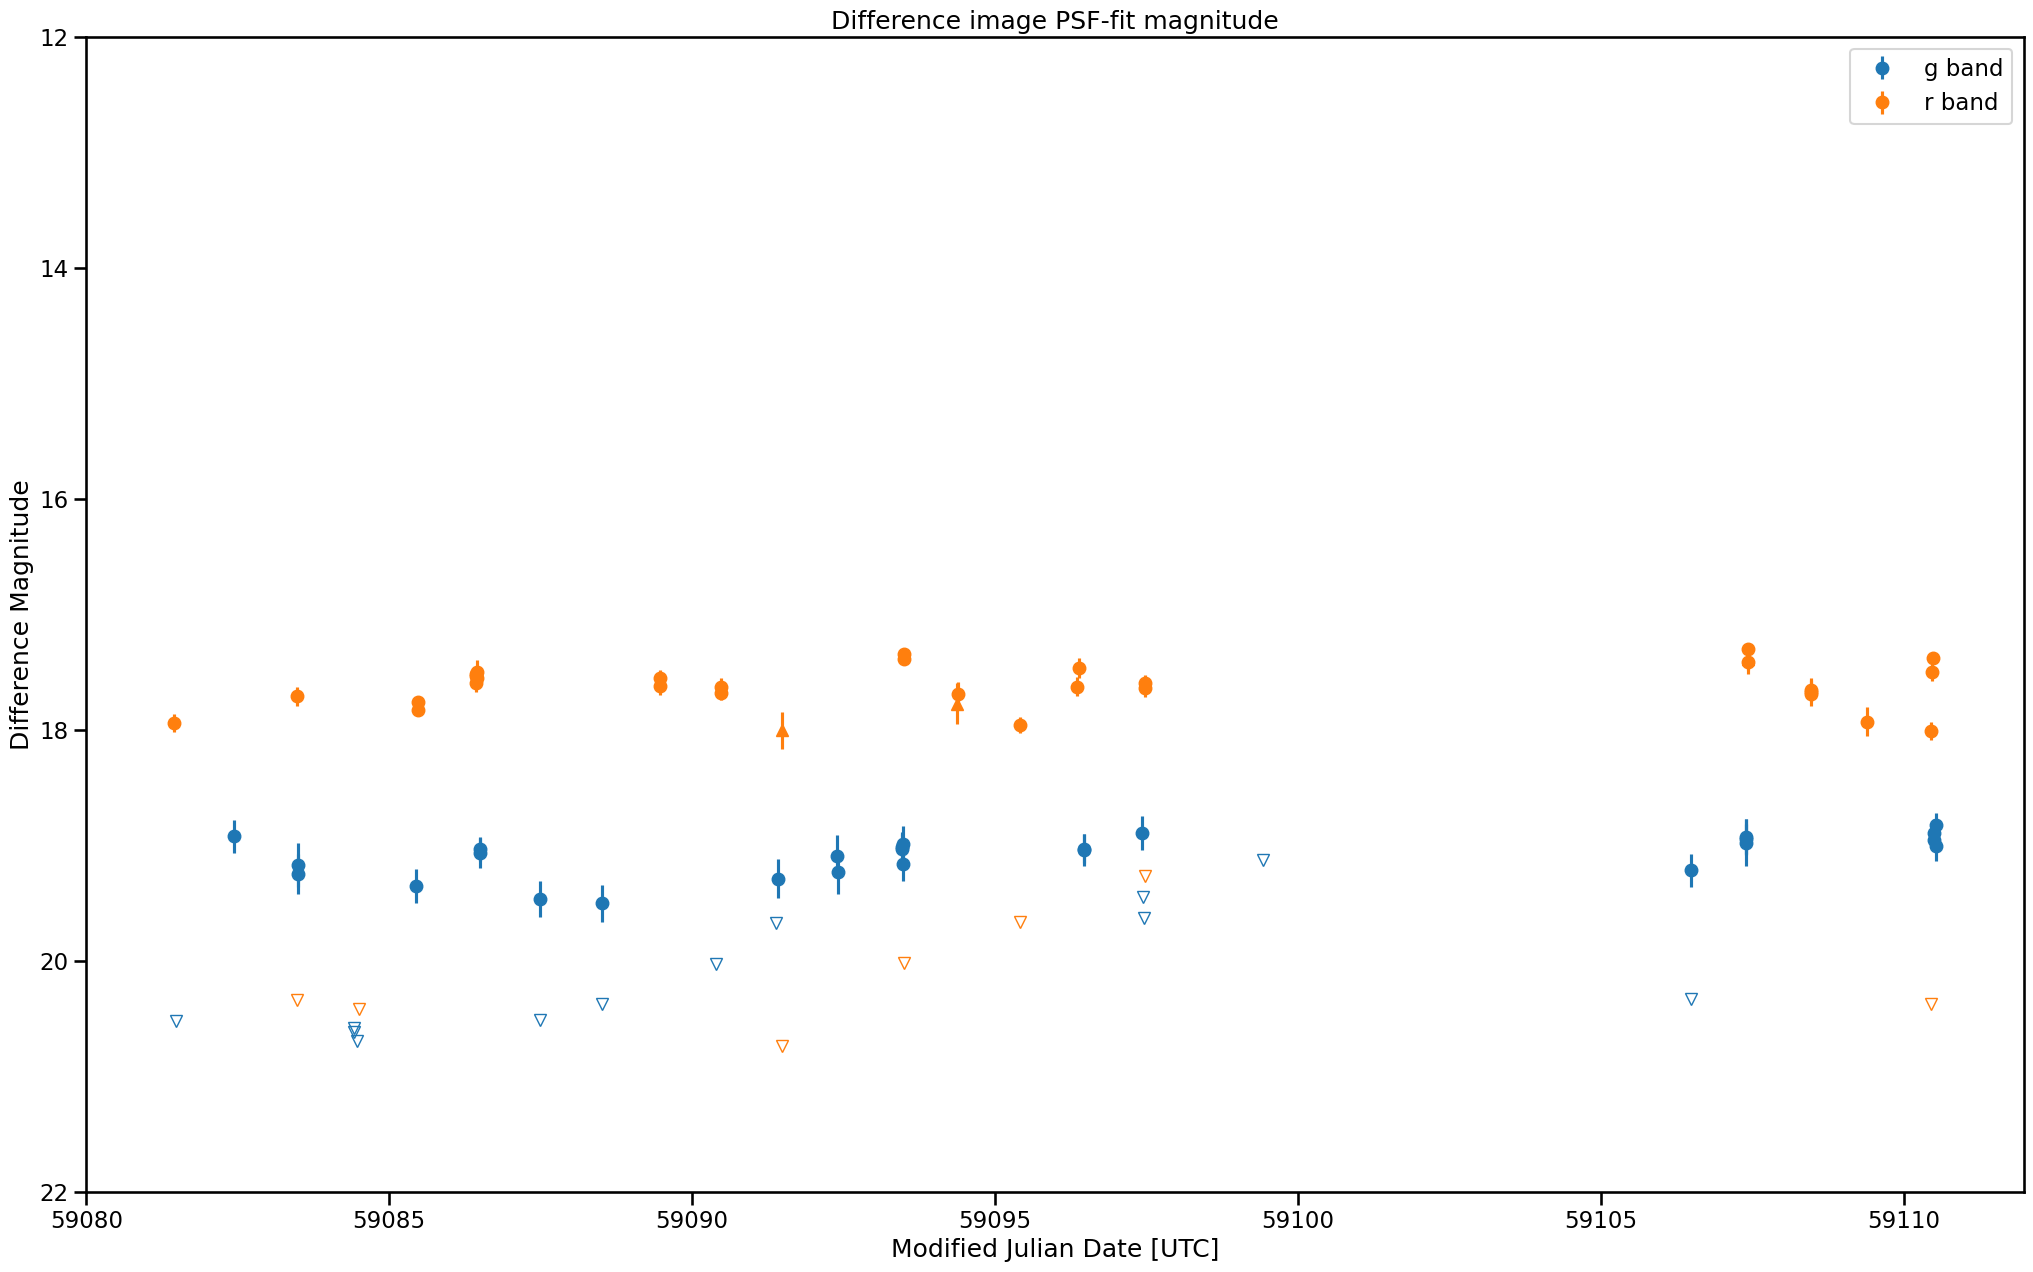

In [18]:

mjd = df['jd'].apply(lambda x: x - 2400000.5)

fig = plt.figure(figsize=(25, 15))

colordic = {1: 'C0', 2: 'C1'}
filtdic = {1: 'g', 2: 'r'}

# valid values 
maskValid = (df['rb'] > 0.55) & (df['nbad'] == 0)
# Upper limit values
maskUpper = pd.isna(df['magpsf'])
#bad quality values 
maskBadquality = ~maskValid & ~maskUpper


for filt in np.unique(df['fid']):
    maskFilt = df['fid'] == filt

    plt.errorbar(
        df[maskValid & maskFilt]['jd'].apply(lambda x: x - 2400000.5),
        df[maskValid & maskFilt]['magpsf'],
        df[maskValid & maskFilt]['sigmapsf'],
        ls = '', marker='o', color=colordic[filt], label='{} band'.format(filtdic[filt])
    )

    plt.plot(
        df[maskUpper & maskFilt]['jd'].apply(lambda x: x - 2400000.5),
        df[maskUpper & maskFilt]['diffmaglim'],
        ls='', marker='v', color=colordic[filt], markerfacecolor='none'
    )
    

    plt.errorbar(
        df[maskBadquality & maskFilt]['jd'].apply(lambda x: x - 2400000.5),
        df[maskBadquality & maskFilt]['magpsf'],
        df[maskBadquality & maskFilt]['sigmapsf'],
        ls='', marker='^', color=colordic[filt]
    )

plt.ylim(12, 22)
plt.gca().invert_yaxis()
plt.legend()
plt.title('Difference image PSF-fit magnitude')
plt.xlabel('Modified Julian Date [UTC]')
plt.ylabel('Difference Magnitude');


# Plot the magnitude difference for valid data.

Distinguishing between positive differences represented by circles and negative differences represented by triangles.

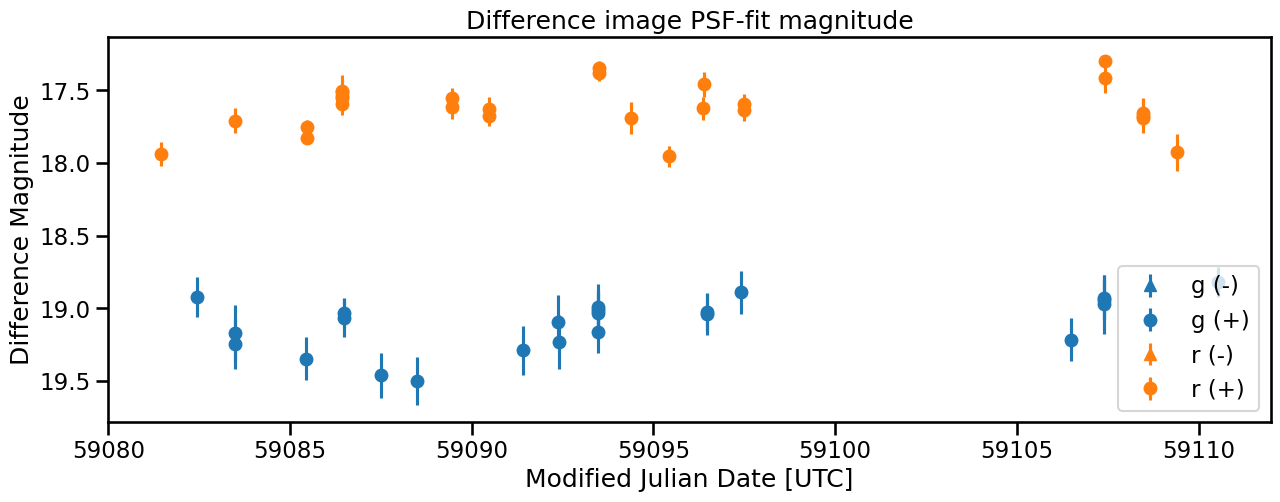

In [25]:
fig = plt.figure(figsize=(15, 5))

colordic = {1: 'C0', 2: 'C1'}
filtdic = {1: 'g', 2: 'r'}
    
maskValid = (df['rb'] > 0.55) & (df['nbad'] == 0)

    
#t or 1 => candidate is from positive (sci minus ref) subtraction;
#f or 0 => candidate is from negative (ref minus sci) subtraction"
maskpos = (df['isdiffpos'] == 't') | (df['isdiffpos'] == 1)
maskneg = (df['isdiffpos'] == 'f') | (df['isdiffpos'] == 0)

for filt in np.unique(df['fid']):
    maskFilt = df['fid'] == filt

    # candidates from negative 

    plt.errorbar(
        df[maskValid & maskFilt & maskneg ]['jd'].apply(lambda x: x - 2400000.5),
        df[maskValid & maskFilt & maskneg ]['magpsf'],
        df[maskValid & maskFilt & maskneg ]['sigmapsf'],
        ls = '', marker='^', color=colordic[filt], label='{} (-)'.format(filtdic[filt])
    )
    
    # candidates from positive 
    plt.errorbar(
        df[maskValid & maskFilt &  maskpos ]['jd'].apply(lambda x: x - 2400000.5),
        df[maskValid & maskFilt &  maskpos ]['magpsf'],
        df[maskValid & maskFilt &  maskpos ]['sigmapsf'],
        ls = '', marker='o', color=colordic[filt], label='{} (+)'.format(filtdic[filt])
    )
    

#plt.ylim(12, 22)
plt.gca().invert_yaxis()
plt.legend()
plt.title('Difference image PSF-fit magnitude')
plt.xlabel('Modified Julian Date [UTC]')
plt.ylabel('Difference Magnitude');



# Verify whether there is a source behind the object.

If so, we compute the magnitude DC using the `dc_mag` function.

 And we have extracted a subset of validated data into a dataframe for further analysis

In [26]:
# from fink_science.conversion import dc_mag
from fink_utils.photometry.conversion import dc_mag
from fink_utils.photometry.utils import is_source_behind

# Take only valid measurements
maskValid = (df['rb'] > 0.55) & (df['nbad'] == 0)
df_valid = df[maskValid].sort_values('jd')

isSource = is_source_behind(
    df_valid['distnr'].values[0]
)

if isSource:
    print('It looks like there is a source behind. Lets compute the DC magnitude instead.')
    
    # Use DC magnitude instead of difference mag
    mag_dc, err_dc = np.transpose(
        [
            dc_mag(*args) for args in zip(
                df_valid['magpsf'].astype(float).values,
                df_valid['sigmapsf'].astype(float).values,
                df_valid['magnr'].astype(float).values,
                df_valid['sigmagnr'].astype(float).values,
                df_valid['isdiffpos'].values
            )
        ]
    )
    
    df_valid['mag_dc'] = mag_dc
    df_valid['err_dc'] = err_dc
else:
    print('No source found -- keeping PSF fit magnitude')
    df_valid['mag_dc'] = df_valid['magpsf']
    df_valid['err_dc'] = df_valid['sigmapsf']



It looks like there is a source behind. Lets compute the DC magnitude instead.


Next, we plot the comparison between PSF-fit magnitudes and DC magnitudes.

15.549999936421711 17.255692408635067


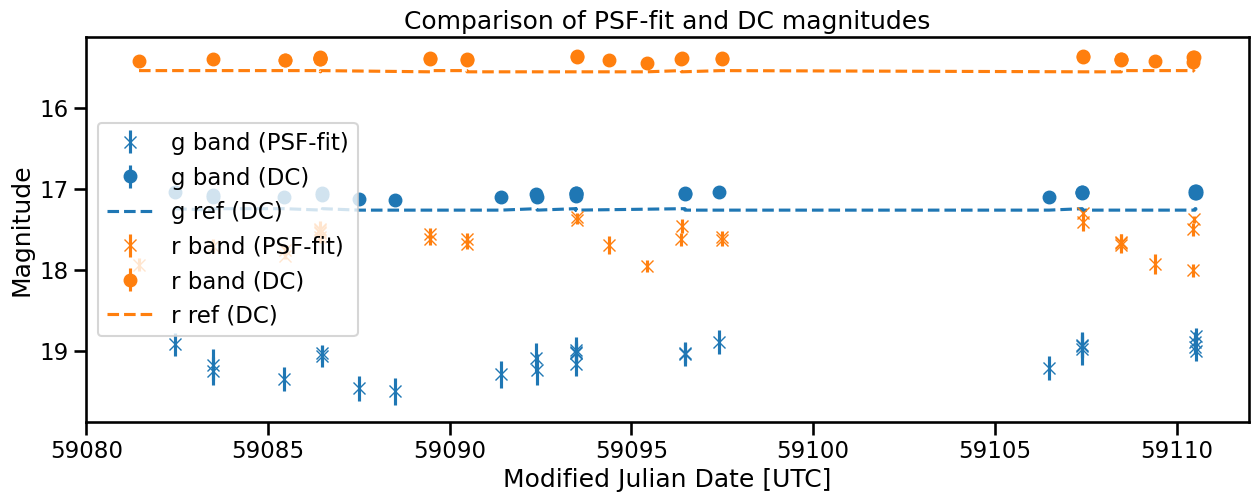

In [28]:
fig = plt.figure(figsize=(15, 5))

colordic = {1: 'C0', 2: 'C1'}
filtdic = {1: 'g', 2: 'r'}

for filt in np.unique(df_valid['fid']):
    maskFilt = df_valid['fid'] == filt

    plt.errorbar(
        df_valid[maskFilt]['jd'].apply(lambda x: x - 2400000.5),
        df_valid[maskFilt]['magpsf'],
        df_valid[maskFilt]['sigmapsf'],
        ls = '', marker='x', 
        color=colordic[filt], 
        label='{} band (PSF-fit)'.format(filtdic[filt]),
    )
    
    
    plt.errorbar(
        df_valid[maskFilt]['jd'].apply(lambda x: x - 2400000.5),
        df_valid[maskFilt]['mag_dc'],
        df_valid[maskFilt]['err_dc'],
        ls = '', marker='o', 
        color=colordic[filt], 
        label='{} band (DC)'.format(filtdic[filt]),
    )
    #To show if there is a variance in the reference( magnitude of the nearest source in the reference image PSF)
    plt.errorbar(
        df_valid[maskFilt]['jd'].apply(lambda x: x - 2400000.5),
        df_valid[maskFilt]['magnr'],
        ls = '--', 
        color=colordic[filt], 
        label='{} ref (DC)'.format(filtdic[filt]),
    )
    

# We calculate the reference value as the average magnitude of the nearest source in the reference image PSF catalog.
ref_r = df_valid[df_valid['fid']==2]['magnr'].mean()

ref_g = df_valid[df_valid['fid']==1]['magnr'].mean()



print(ref_r, ref_g)
#  Average Values (Used in Fink)
#plt.axhline(y=ref_r, color=colordic[2], linestyle='--')
#plt.axhline(y=ref_g, color=colordic[1], linestyle='--')
plt.gca().invert_yaxis()
plt.legend()
plt.title('Comparison of PSF-fit and DC magnitudes')
plt.xlabel('Modified Julian Date [UTC]')
plt.ylabel('Magnitude');

# Calculate and plot Apparent DC flux  

We utilize a function(`apparent_flux`) located within the `fink_utils` folder to compute the apparent flux for the valid data.

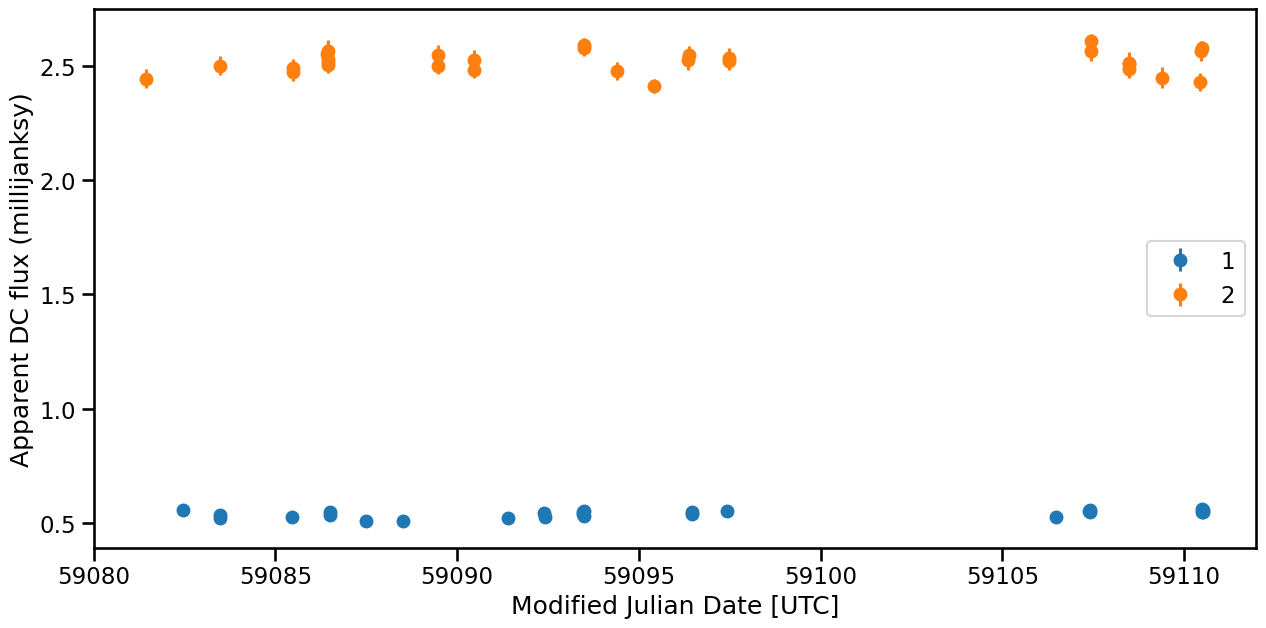

In [29]:
fig = plt.figure(figsize=(15, 7))

from fink_utils.photometry.conversion import apparent_flux


dc_flux, dc_sigflux = np.transpose(
        [
            apparent_flux(*args, jansky=True) for args in zip(
                df_valid['magpsf'].astype(float).values,
                df_valid['sigmapsf'].astype(float).values,
                df_valid['magnr'].astype(float).values,
                df_valid['sigmagnr'].astype(float).values,
                df_valid['isdiffpos'].values
            )
        ]
)

df_valid['dc_flux'] = dc_flux
df_valid['dc_sigflux'] = dc_sigflux


for filt in np.unique(df['fid']):
    mask = df_valid['fid'] == filt
    sub = df_valid[mask]
    plt.errorbar(
        sub['jd'].apply(lambda x: x - 2400000.5),
        sub['dc_flux']*1e3,
        sub['dc_sigflux']*1e3,
        ls='', 
        marker='o',
        label=filt
    )
plt.legend()

plt.xlabel('Modified Julian Date [UTC]')
plt.ylabel('Apparent DC flux (millijanksy)');


# Apparent flux for the nearest source

We create a function `apparent_flux` to determine the apparent flux for the nearest source in the reference image.

In [31]:
import numpy as np
from typing import Tuple

def flux_nr(
    magnr: float,
    sigmagnr: float,
    jansky: bool = True

) -> Tuple[float, float]:
    """
    
    Parameters
    ---------

    Returns
    --------
    dc_flux: float
        Apparent flux
    dc_sigflux: float
        Error on apparent flux
    """

    nr_flux = 10 ** (-0.4 * magnr)
    
    nr_sigflux = np.log(10) * 0.4 * nr_flux *sigmagnr # dc_flux ! 
    
    if jansky:
        nr_flux *= 3631
        nr_sigflux *= 3631

    return nr_flux, nr_sigflux

nr_flux, nr_sigflux = np.transpose(
        [
            flux_nr(*args, jansky=True) for args in zip(
                df_valid['magnr'].astype(float).values,
                df_valid['sigmagnr'].astype(float).values
            )
        ]
)

df_valid['nr_flux'] = nr_flux
df_valid['nr_sigflux'] = nr_sigflux



# Data missing 


Our objective here is to retrieve the missing data values, particularly for cases where they represent upper limits.

In [32]:
# Take only Upper limits data
maskUpper = pd.isna(df['magpsf'])

df_Upper = df[maskUpper].sort_values('jd')#, ascending=False)


Compute the average of the sigma magnitude values for the nearest sources.

In [33]:
sigmnr_r = df_valid[df_valid['fid']==2]['sigmagnr'].mean()
sigmnr_g = df_valid[df_valid['fid']==1]['sigmagnr'].mean()

We define a function named `apparent_flux_Upper` to calculate the apparent flux, along with its associated sigma (error), for both the DC flux and NR flux, specifically for data representing upper limits.

In [34]:
import numpy as np
from typing import Tuple

def apparent_flux_Upper(
    diffmaglim: float,
    fid: int,
    ref_r: float,
    ref_g: float,
    sigmnr_r: float,
    sigmnr_g: float,
    jansky: bool = True

) -> Tuple[float, float]:
    """
    
    Parameters
    ---------

    Returns
    --------
    dc_flux: float
        Apparent flux
    dc_sigflux: float
        Error on apparent flux
    """
    

    if (fid == 1):
        mnr = ref_g
        sigmnr = sigmnr_g
    if (fid == 2):
        mnr = ref_r
        sigmnr = sigmnr_r

    dc_flux = 10 ** (-0.4 * mnr)
    
    sig_c = (10 ** (-0.4 * diffmaglim))/np.sqrt(3) * 4.65 # (normalisation* ! )
    sig_flux_nr = np.log(10) * 0.4 * (10 ** (-0.4 * mnr)) *sigmnr # dc_flux ! 
    
    dc_sigflux = np.sqrt(sig_c**2 + sig_flux_nr**2)

    if jansky:
        dc_flux *= 3631
        dc_sigflux *= 3631
        sig_flux_nr *= 3631

    return dc_flux, dc_sigflux, sig_flux_nr


In [35]:

dc_flux, dc_sigflux,nr_sigflux = np.transpose(
        [
            apparent_flux_Upper(*args, ref_r, ref_g, sigmnr_r, sigmnr_g, jansky=True) for args in zip(
                df_Upper['diffmaglim'].astype(float).values,
                df_Upper['fid'].astype(int).values,

            )
        ]
)

df_Upper['dc_flux'] = dc_flux
df_Upper['dc_sigflux'] = dc_sigflux
df_Upper['nr_sigflux'] = nr_sigflux
df_Upper['nr_flux'] = dc_flux


# Plot the apparent DC flux (in millijansky) for both valid and upper limits data.

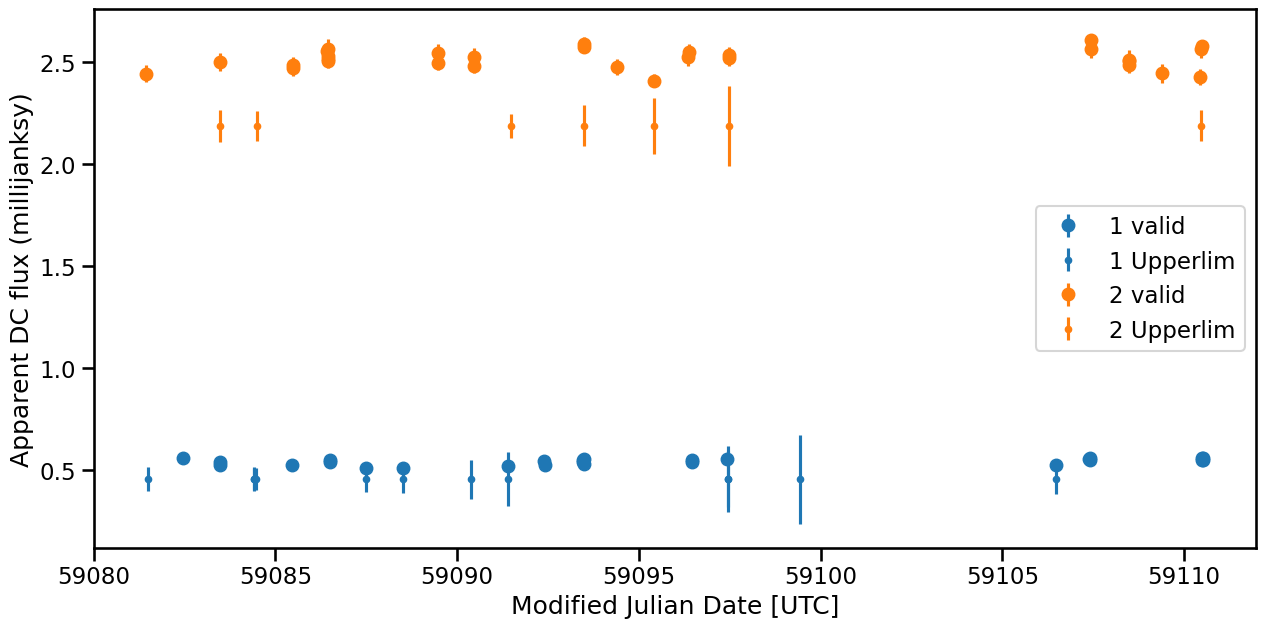

In [36]:
fig = plt.figure(figsize=(15, 7))


for filt in np.unique(df['fid']):
    mask = df_valid['fid'] == filt
    sub = df_valid[mask]
    plt.errorbar(
        sub['jd'].apply(lambda x: x - 2400000.5),
        sub['dc_flux']*1e3, 
        sub['dc_sigflux']*1e3,
        ls='', 
        marker='o',
        color=colordic[filt], 

        label=f"{filt} valid"
    )
    
    mask2 = df_Upper['fid'] == filt

    plt.errorbar(
        df_Upper[mask2]['jd'].apply(lambda x: x - 2400000.5),
        df_Upper[mask2]['dc_flux']*1e3,
        df_Upper[mask2]['dc_sigflux']*1e3,
        ls='', 
        marker='.',
        color=colordic[filt], 

        label=f"{filt} Upperlim"
    )
    
    
    
plt.legend()

plt.xlabel('Modified Julian Date [UTC]')
plt.ylabel('Apparent DC flux (millijanksy)');

# Combine Upper with valid 

We merge the data from the upper limit and valid datasets based on specific columns.

In [37]:
columns_to_keep = ['jd', 'fid','dc_flux', 'dc_sigflux', 'nr_flux', 'nr_sigflux']
combined_df = pd.concat([df_Upper[columns_to_keep], df_valid[columns_to_keep]], axis=0)

In [40]:
combined_df.sort_index(inplace=True)

In [41]:
combined_df.head(2)

,jd,fid,dc_flux,dc_sigflux,nr_flux,nr_sigflux
0,2.459082e+06,2,0.002445,0.000041,0.002202,0.000037
1,2.459082e+06,1,0.000455,0.000061,0.000455,0.000008


# Data by days 

Here, we group the data by modified Julian date on a daily basis and by filter ID (1 for g, 2 for R, 3 for i), computing the average values of flux and sigma flux(for both DC and NR) using the `Weighted_Mean` functions.

In [42]:
combined_df['mjd'] = combined_df['jd'].apply(lambda x: x - 2400000.5)

In [43]:
# Convert 'mjd' to integer to remove fractional part
combined_df['mjd'] = combined_df['mjd'].astype(int)
df2 = combined_df.groupby(['mjd','fid'])

In [44]:
# I should generelaize this one ! 
def Weighted_Mean_dc(group):
    N= len(group)
    if N ==1 :
        return pd.Series({'dc_flux': group['dc_flux'].iloc[0], 'dc_sigflux': group['dc_sigflux'].iloc[0]}) 
    
    wi = 1/group['dc_sigflux']**2

    x_bar = (group['dc_flux']*wi).sum() / wi.sum()
    
    x_2 = ((group['dc_flux'] - x_bar)**2 *wi).sum()
    
    sigma_x = np.sqrt(1/ wi.sum())
    
    fact = np.sqrt(x_2/ (N-1))
    
    if (fact >= 1) : 
        sigma_x *= fact
    return pd.Series({'dc_flux': x_bar, 'dc_sigflux': sigma_x})
    #return pd.Series(x_bar , index=[group.index[0]]),pd.Series(sigma_x , index=[group.index[0]])
    

In [54]:
df_mod = pd.DataFrame()
df_mod = df2.apply(Weighted_Mean_dc)

In [55]:
df_mod.head(2)

dc_flux  dc_sigflux
mjd   fid                      
59081 1    0.000455    0.000061
      2    0.002445    0.000041

In [56]:
def Weighted_Mean_nr(group):
    N= len(group)
    if N ==1 :
        return pd.Series({'nr_flux': group['nr_flux'].iloc[0], 'nr_sigflux': group['nr_sigflux'].iloc[0]}) 
    
    wi = 1/group['nr_sigflux']**2

    x_bar = (group['nr_flux']*wi).sum() / wi.sum()
    
    x_2 = ((group['nr_flux'] - x_bar)**2 *wi).sum()
    
    sigma_x = np.sqrt(1/ wi.sum())
    
    fact = np.sqrt(x_2/ (N-1))
    
    if (fact >= 1) : 
        sigma_x *= fact
    return pd.Series({'nr_flux': x_bar, 'nr_sigflux': sigma_x})
    #return pd.Series(x_bar , index=[group.index[0]]),pd.Series(sigma_x , index=[group.index[0]])
    

In [57]:
df_mod[['nr_flux', 'nr_sigflux']] = df2.apply(Weighted_Mean_nr)

In [58]:
# Only once ! i need to solve this prob...
df_mod.reset_index(inplace=True)

In [59]:
df_mod.head(2)

,mjd,fid,dc_flux,dc_sigflux,nr_flux,nr_sigflux
0,59081,1,0.000455,0.000061,0.000455,0.000008
1,59081,2,0.002445,0.000041,0.002202,0.000037


# Fill the missing days ! 

If there are missing days without alerts in the data, we can fill these gaps by inserting average values.

In [67]:
df_mod[['mjd','fid']]

,mjd,fid
0,59081,1
1,59081,2
2,59082,1
3,59083,1
4,59083,2
5,59084,1
6,59084,2
7,59085,1
8,59085,2
9,59086,1


# Create a final dataframe to consolidate the values of this alert into a single row.

In this dataframe, include another dataframe as a dictionary containing the values of flux, sigma, and so on.

In [60]:
df_anomaly = pd.DataFrame()
df_anomaly['objectId'] = [pdf_selectionne.objectId]
df_anomaly['candid'] = [pdf_selectionne.candid]
df_anomaly['jd'] = [pdf_selectionne.candidate['jd']]
df_anomaly['df'] = [df_mod.to_dict()]

In [61]:
df_anomaly

,objectId,candid,jd,df
0,ZTF18adbmoft,1356527403015015001,2.459111e+06,"{'mjd': {0: 59081, 1: 59081, 2: 59082, 3: 5908..."


In [63]:
#Here's an example of how we can utilize the dataframe of the first row:
df = pd.DataFrame.from_dict(df_anomaly['df'].iloc[0])

In [64]:
df.head(3)

,mjd,fid,dc_flux,dc_sigflux,nr_flux,nr_sigflux
0,59081,1,0.000455,0.000061,0.000455,0.000008
1,59081,2,0.002445,0.000041,0.002202,0.000037
2,59082,1,0.000557,0.000015,0.000459,0.000008


# Trash 

In [ ]:
df_valid[(df_valid['mjd']).astype(int) == 59089 ][['fid', 'dc_flux','dc_sigflux']]

In [ ]:
df_Upper[(df_Upper['mjd']).astype(int) == 59089 ][['fid','dc_flux','dc_sigflux']]

In [ ]:
s1=np.array((0.000015,0.000109))
f1=np.array((0.000669,0.000828))
f1bar=np.sum(f1/s1**2)/np.sum(1/s1**2)
print(f1bar)
print('chi2',(f1-f1bar)**2/s1**2)

In [ ]:
fig = plt.figure(figsize=(15, 7))


for filt in np.unique(df['fid']):
    mask = df['fid'] == filt
    sub = df
    plt.errorbar(
        sub[mask]['mjd'],
        sub[mask]['dc_flux']*1e3, 
        sub[mask]['dc_sigflux']*1e3,
        ls='', 
        marker='o',
        color=colordic[filt], 

        label=f"{filt} all flux dc"
    )
    

    plt.errorbar(
        df[mask]['mjd'],
        df[mask]['nr_flux']*1e3,
        df[mask]['nr_sigflux']*1e3,
        ls='', 
        marker='.',
        color=colordic[filt], 

        label=f"{filt} all nr"
    )
    
    
    
plt.legend()

plt.xlabel('Modified Julian Date [UTC]')
plt.ylabel('Apparent  DC and nr flux (millijanksy)');

In [ ]:
fig = plt.figure(figsize=(15, 7))


for filt in np.unique(df['fid']):
    mask = df_valid['fid'] == filt
    sub = df_valid[mask]
    plt.errorbar(
        sub['jd'].apply(lambda x: x - 2400000.5),
        sub['dc_flux']*1e3, 
        sub['dc_sigflux']*1e3,
        ls='', 
        marker='o',
        color=colordic[filt], 

        label=f"{filt} valid"
    )
    
    mask2 = df_Upper['fid'] == filt

    plt.errorbar(
        df_Upper[mask2]['jd'].apply(lambda x: x - 2400000.5),
        df_Upper[mask2]['dc_flux']*1e3,
        df_Upper[mask2]['dc_sigflux']*1e3,
        ls='', 
        marker='.',
        color=colordic[filt], 

        label=f"{filt} Upperlim"
    )
    
    
    
plt.legend()

plt.xlabel('Modified Julian Date [UTC]')
plt.ylabel('Apparent DC flux (millijanksy)');

In [ ]:
"""def sig_Mean_error(group):
    N= len(group)
    if N ==1 :
        return group['dc_sigflux']

    wi = 1/group['dc_sigflux']**2
    
    x_bar = (group['dc_flux']*wi).sum() / wi.sum()
    
    x_2 = ((group['dc_flux'] - x_bar)**2 *wi).sum()

    sigma_x = np.sqrt(1/ wi.sum())
    
    fact = np.sqrt(x_2/ (N-1))
    
    if (fact >= 1) : 
        sigma_x *= fact
   
    return pd.Series(sigma_x, index=[group.index[0]])
"""